In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import scipy
import warnings
warnings.filterwarnings("ignore") 
#训练样本的目录
train_dir='./NewThree_Dataset/train'
#验证样本的目录
validation_dir='./NewThree_Dataset/val'
#测试样本目录
test_dir='./NewThree_Dataset/test'

2025-05-29 18:27:16.725644: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:

#训练集生成器---训练集数据加强
train_datagen=ImageDataGenerator(
    rescale=1./255,#所有数据集将乘以该数值
    rotation_range=40,#随即旋转角度数范围
    width_shift_range=0.2,#随即宽度偏移量
    height_shift_range=0.2,#随即高度偏移量
    shear_range=0.2,#错切变换
    zoom_range=0.2,#随机缩放的范围 -> [1-n,1+n]
    horizontal_flip=True,#是否随机水平翻转
    fill_mode='nearest')
 
train_generator=train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224,224),
    batch_size=64
)
 
#验证样本生成器
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=validation_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(224,224),
    batch_size=64
)
 
#测试样本生成器
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    batch_size=64,
    shuffle=False
)
print(train_generator.class_indices)
print(test_generator.class_indices)
print(validation_generator.class_indices)


Found 4189 images belonging to 3 classes.
Found 1150 images belonging to 3 classes.
Found 1267 images belonging to 3 classes.
{'MildDemented': 0, 'NonDemented': 1, 'VeryMildDemented': 2}
{'MildDemented': 0, 'NonDemented': 1, 'VeryMildDemented': 2}
{'MildDemented': 0, 'NonDemented': 1, 'VeryMildDemented': 2}


In [3]:
#VGG 16实例化---使用imagenet数据集训练，不包含顶层(即全连接层)
conv_base = VGG16(weights='imagenet',
                  include_top=False,  #是否指定模型最后是否包含密集连接分类器
                  input_shape=(224, 224, 3))

conv_base.trainable = True
 
conv_base.summary()

2025-05-29 18:27:19.013382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-29 18:27:19.666474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22028 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:36:00.0, compute capability: 8.9


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
#构建网络模型----基于VGG16建立模型
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten(input_shape=conv_base.output_shape[1:]))  #图片输出四维，1代表数量
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax')) 

# 转换为推理图
model_function = tf.function(lambda inputs: model(inputs))
concrete_function = model_function.get_concrete_function(tf.TensorSpec([1, 224, 224, 3], model.inputs[0].dtype))

# 转换模型为静态图
frozen_func = convert_variables_to_constants_v2(concrete_function)

# 获取模型的图定义
graph = frozen_func.graph

# 使用 TensorFlow 1.x 中的 profiler 计算 FLOPs
with tf.compat.v1.Session(graph=graph) as sess:
    flops = tf.compat.v1.profiler.profile(
        graph=sess.graph,
        options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    )
    print('FLOPs: {}'.format(flops.total_float_ops))


2025-05-29 18:27:20.465380: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-05-29 18:27:20.465609: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-05-29 18:27:20.470656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22028 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:36:00.0, compute capability: 8.9


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


2025-05-29 18:27:21.516310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22028 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:36:00.0, compute capability: 8.9



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

In [5]:
#定义优化器、代价函数、训练过程中计算准确率
model.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

#设置 EarlyStopping 回调
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

#设置 ReduceLROnPlateau 回调
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-6)

# 计算每个epoch的steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 21,138,243
Non-trainable params: 0
_________________________________________________________________


In [6]:
#拟合模型
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)
#保存模型
model.save('.Alz/VGG 16.h5')
 
#评估测试集的准确率
test_eval=model.evaluate_generator(test_generator)
print("测试集准确率：",test_eval)
train_eval=model.evaluate_generator(train_generator)
print("训练集准确率：",train_eval)
val_eval=model.evaluate_generator(validation_generator)
print("验证集准确率：",val_eval)

Epoch 1/100


2025-05-29 18:27:24.227726: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-05-29 18:27:25.021879: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-05-29 18:27:25.021918: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-05-29 18:27:25.022043: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-05-29 18:27:26.135909: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


65/65 [==============================] - 39s 525ms/step - loss: 1.0296 - acc: 0.4974 - val_loss: 0.9762 - val_acc: 0.5506 - lr: 1.0000e-04
Epoch 2/100
65/65 [==============================] - 35s 532ms/step - loss: 0.9998 - acc: 0.5122 - val_loss: 0.9651 - val_acc: 0.5478 - lr: 1.0000e-04
Epoch 3/100
65/65 [==============================] - 34s 523ms/step - loss: 0.9889 - acc: 0.5176 - val_loss: 0.9703 - val_acc: 0.5460 - lr: 1.0000e-04
Epoch 4/100
65/65 [==============================] - 35s 531ms/step - loss: 0.9882 - acc: 0.5168 - val_loss: 0.9627 - val_acc: 0.5551 - lr: 1.0000e-04
Epoch 5/100
65/65 [==============================] - 35s 533ms/step - loss: 0.9919 - acc: 0.5161 - val_loss: 0.9699 - val_acc: 0.5478 - lr: 1.0000e-04
Epoch 6/100
65/65 [==============================] - 34s 524ms/step - loss: 0.9847 - acc: 0.5183 - val_loss: 0.9565 - val_acc: 0.5542 - lr: 1.0000e-04
Epoch 7/100
65/65 [==============================] - 35s 531ms/step - loss: 0.9856 - acc: 0.5149 - val_los

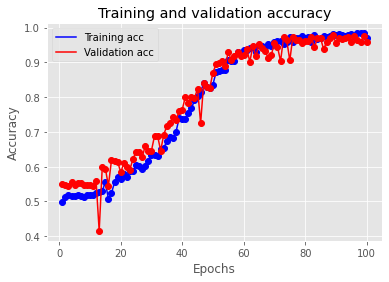

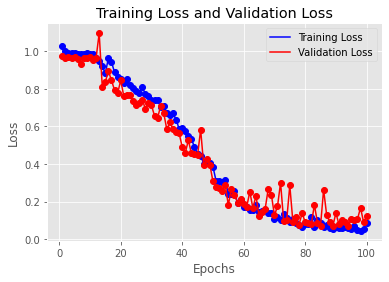

In [7]:
plt.style.use('ggplot')
#绘制训练过程中的损失曲线和精度曲线
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs,val_acc, 'ro')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, loss,'b', label ='Training Loss')
plt.plot(epochs, val_loss,'ro')
plt.plot(epochs, val_loss,'r',label='Validation Loss')
 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss and Validation Loss")
plt.legend()

20/20 [==============================] - 2s 71ms/step


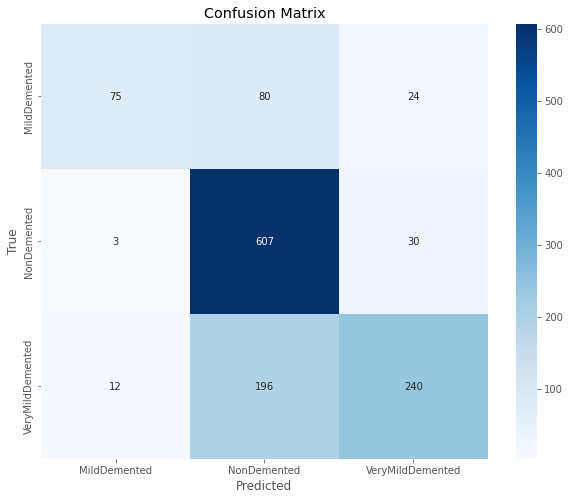

Classification Report
                  precision    recall  f1-score   support

    MildDemented       0.83      0.42      0.56       179
     NonDemented       0.69      0.95      0.80       640
VeryMildDemented       0.82      0.54      0.65       448

        accuracy                           0.73      1267
       macro avg       0.78      0.63      0.67      1267
    weighted avg       0.75      0.73      0.71      1267



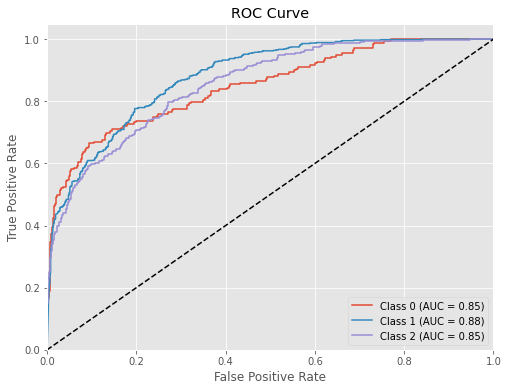

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.utils import to_categorical
import numpy as np

from keras.models import load_model

# 加载训练好的模型
model = load_model('.Alz/VGG 16.h5')

# 获取预测值和真实标签
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# 混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 分类报告
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# 定义类别数量
num_classes = 3 

# 转换真实标签为二进制格式
y_true_binary = to_categorical(y_true, num_classes=num_classes)

# 绘制AUC曲线
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()